In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from model.MatrixTransfer import TransMatrixGLM
from model.utils import batch_mat_prod
from tqdm import tqdm
from model.utils import multi_task
from simulation.coef import *
from simulation.data import *
from simulation.utils import *
from typing import Callable
import warnings
warnings.filterwarnings("ignore")

In [2]:
# plot simulation results
def plot_simulation(res_linear,res_logistic,h_list,x,y,K,ylims1=None,ylims2=None):
    fig, ax = plt.subplots(2,3,figsize=(10,5),dpi=120)
    ax = ax.flatten()
    sns.set_style("darkgrid")
    sns.set_context("paper")
    for i, h in enumerate(h_list):
        l = sns.pointplot(data=res_linear.loc[res_linear["h"]==h],
            x=x,y=y,hue="method",ax=ax[i],palette=["#FF7256","#9f79ee","#ff83fa","#00c5cd","#c2dd58"],ci=95,errwidth=1.2,scale=1)
        ax[i].set_title("Linear case ($h$=%d)"%(h))
        ax[i].get_legend().remove()
        ax[i].set_xticks(list(range(0,K)))
        ax[i].set_xticklabels(list(range(1,K+1)))
        ax[i].set_ylabel("Frobenius error of estimation")
        ax[i].set_xlabel("$K$")
        ax[i].set_yticks([50,60,70])
        # ax[i].set_ylim(ylims1)
    for i, h in enumerate(h_list):
        l = sns.pointplot(data=res_logistic.loc[res_logistic["h"]==h],
            x=x,y=y,hue="method",ax=ax[i+3],palette=["#FF7256","#9f79ee","#ff83fa","#00c5cd","#c2dd58"],ci=95,errwidth=1.2,scale=1)
        ax[i+3].set_title("Logistic case ($h$=%d)"%(h))
        ax[i+3].get_legend().remove()
        ax[i+3].set_xticks(list(range(0,K)))
        ax[i+3].set_xticklabels(list(range(1,K+1)))
        ax[i+3].set_ylabel("Frobenius error of estimation")
        ax[i+3].set_xlabel("$K$")
        # ax[i+3].set_yticks([45,55,65,75])
        # ax[i+3].set_ylim(ylims2)
    lines=[]
    labels=["naive-Lasso","naive-Nuclear","$\mathcal{A}$-Lasso-Lasso","$\mathcal{A}$-Nuclear-Lasso","$\mathcal{A}$-Nuclear-Nuclear"]
    for ax in fig.axes[0:1]:
        axLine, axLabel = ax.get_legend_handles_labels()
        lines.extend(axLine)
    fig.legend(
        lines[0:5], labels[0:5],loc="lower center",
        bbox_to_anchor=(0.5, -0.05), ncol=5, 
        title=None, frameon=False,edgecolor="red")
    plt.tight_layout()

## Section4.1: Transfer learning under known $\mathcal{A}$

### Under Setting $\mathcal{A}_h^{vec}$

#### Linear Case

In [5]:
# init results
models = ["naive-Lasso","naive-Nuclear","A-Lasso-Lasso","A-Nuclear-Lasso","A-Nuclear-Nuclear"]
h_list = [200,500,1000]
result, penalties = Sec41_simulation(
    models=models,task="regression",h_list=h_list,coef_func=GenerateCoef_vec,data_func=regression_data)
# result.to_csv("./results/simulation_sec4_knownA_vec_linear.csv",index=False)
result.head()

,h,K,repeat,method,err,score
0,200,NaN,NaN,NaN,NaN,NaN
1,NaN,1,NaN,NaN,NaN,NaN
2,NaN,NaN,1,NaN,NaN,NaN
3,NaN,NaN,NaN,naive-Lasso,NaN,NaN
4,NaN,NaN,NaN,NaN,76.656824,NaN


#### Binary Logistic Case (Fixed)

#### CV参数调整结果

* naive-Lasso：lambda 范围 1e-3 至 1e-2，err 约 70，lambda 越大，err 越小，使用 auto
  * 固定到：4.5e-3
* naive-nuclear: lambda 取值 1e-2 至 5e-2，err 约 60，lambda 越大，err 越小，使用 auto，可取 top = 1 或 top = 5
  * 固定到：3e-2
* A-Lasso-Lasso: transfer_lambda 取值 5e-3 至 1e-2，debias_lambda 取值 1e-3 至 5e-3，使用 auto
  * 待选值： *[5e-3, 6e-3]
  * 不能够通过CV找到合适的解
  * CV曲线异常，在最优惩罚系数下，oof 的误差反而最大
* A-Nuclear-Lasso: transfer_lambda 取值 1e-2 至 5e-2， debias_lambda 取值 1e-2 至 5e-2，使用 auto
  * 固定到：[3e-2, 4e-2]
  * CDN Lasso对惩罚项的调整有一些敏感
* A-Nuclear-Nuclear: transfer_lambda 取值 1e-2 至 5e-2， debias_lambda 取值 1e-2 至 5e-2，使用 auto
  * 固定到：[3e-2, 3e-2], [3e-2, 4e-2]

In [3]:
# init results
models = ["naive-Lasso","naive-Nuclear","A-Lasso-Lasso","A-Nuclear-Lasso","A-Nuclear-Nuclear"]
optimal_lambdas = {
    "transfer_naive-Lasso": 0, "debias_naive-Lasso": 4.5*1e-3, 
    "transfer_naive-Nuclear": 0, "debias_naive-Nuclear": 3e-2,
    "transfer_A-Lasso-Lasso": 5*1e-3, "debias_A-Lasso-Lasso": 6*1e-3,
    "transfer_A-Nuclear-Lasso": 3e-2, "debias_A-Nuclear-Lasso": 4e-2,
    "transfer_A-Nuclear-Nuclear": 3e-2, "debias_A-Nuclear-Nuclear": 4e-2}
h_list = [200,500,1000]
result,_ = Sec41_simulation(
    models=models,task="classification",h_list=h_list,
    coef_func=GenerateCoef_vec,data_func=binary_logistic_data,
    replicate=100,Kmax=10,scale="auto",n_jobs=12,
    optimal_lambda=optimal_lambdas,base=True)
# result.to_csv("./results/simulation_sec4_knownA_vec_logistic.csv",index=False)
result.head()

Fitting on h: 1000, K: 10, model: A-Nuclear-Nuclear: 100%|██████████████████████████| 150/150 [1:01:06<00:00, 24.44s/it]


,h,K,repeat,method,err,score,time
0,200,1,1,naive-Lasso,69.592845,0.98,0.555997
1,200,1,2,naive-Lasso,74.237034,0.96,0.580001
2,200,1,3,naive-Lasso,77.048348,0.97,0.577999
3,200,1,4,naive-Lasso,66.39962,0.945,0.617993
4,200,1,5,naive-Lasso,74.214713,0.99,0.571000


In [18]:
result.loc[result["K"] <= 4,:].groupby(by=["method"])["time"].mean()

method
A-Lasso-Lasso        2.152514
A-Nuclear-Lasso      0.390467
A-Nuclear-Nuclear    0.094689
naive-Lasso          0.705474
naive-Nuclear        0.014337
Name: time, dtype: float64

In [16]:
result.loc[result["K"] <= 4,:].groupby(by=["method"])["time"].std()

method
A-Lasso-Lasso        0.781857
A-Nuclear-Lasso      0.149780
A-Nuclear-Nuclear    0.295896
naive-Lasso          0.182166
naive-Nuclear        0.003088
Name: time, dtype: float64

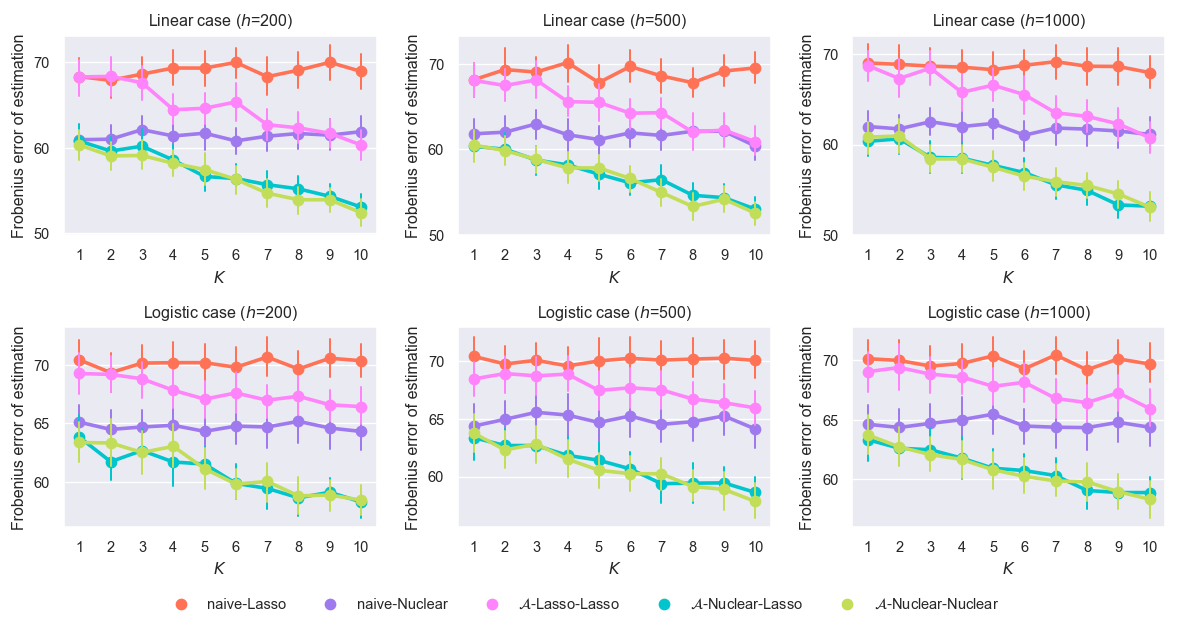

In [416]:
res_linaer = pd.read_csv("./results/simulation_sec4_knownA_vec_linear.csv")
res_logistic = pd.read_csv("./results/simulation_sec4_knownA_vec_logistic.csv")
plot_simulation(res_linaer,res_logistic,[200,500,1000],"K","err",10,[50,72],[56,72])

### Under Setting $\mathcal{A}_h^{\sigma}$

In [3]:
def Sec41_simulation(
    models : list, coef_func : Callable, data_func : Callable, task : str,
    h_list : list, Kmax : int=10, replicate : int=100, tuning_rounds : int=3,
    lambda_min_ratio : float=0.01, lambda_max_ratio : float=5, 
    metric : str=None, scale : str="none",n_jobs : int=16, top : int=1, optimal_lambda : Optional[dict]=None, base : Optional[bool]=True):
    # init results
    result = pd.DataFrame(data=None,columns=["h","K","repeat","method","err","score"])
    penaltoes = pd.DataFrame(data=None,columns=["h","K","method","transfer","debias"])
    # show progress
    pbar = tqdm(total=len(h_list)*Kmax*len(models),ncols=120)
    tuning = True if optimal_lambda is None else False
    for h in h_list:
        for K in range(1,Kmax+1):
            # find optimal penalty coef
            if tuning:
                optimal_lambda = {}
                for m in models:
                    optimal_lambda["transfer_%s"%(m)] = 0 
                    optimal_lambda["debias_%s"%(m)] = 0
                for m in models:
                    pbar.set_description("Tuning on h: %4d, K: %2d, model: %s"%(h,K,m))
                    A_set = None if "naive" in m else list(range(K))
                    for i in range(tuning_rounds):
                        B, W = coef_func(h=h,K=K)
                        X_target, X_source, y_target, y_source = data_func(B=B,W=W,scale=scale)
                        model = CreateModel(model=m,task=task)
                        best_lambda_transfer, best_lambda_debias, _, _ =\
                            model.tuning(
                                Xt=X_target,yt=y_target,Xa=X_source,ya=y_source,A=A_set,
                                lambda_min_ratio=lambda_min_ratio,lambda_max_ratio=lambda_max_ratio,
                                metric=metric,top=top,n_jobs=n_jobs)
                        optimal_lambda["transfer_%s"%(m)] += best_lambda_transfer / tuning_rounds
                        optimal_lambda["debias_%s"%(m)] += best_lambda_debias / tuning_rounds
                    penaltoes.loc[len(penaltoes),:] =\
                     [h,K,m,optimal_lambda["transfer_%s"%(m)],optimal_lambda["debias_%s"%(m)]]
            # replications
            for m in models:
                # update progress
                pbar.set_description("Fitting on h: %4d, K: %2d, model: %s"%(h,K,m))
        
                # create a parameter list for parallel execution
                A_set = None if "naive" in m else list(range(K))
                param_list = []
                for repeat in range(replicate):
                    B, W = coef_func(h=h,K=K)
                    X_target, X_source, y_target, y_source = data_func(B=B,W=W,scale=scale)
                    lambda_transfer = optimal_lambda["transfer_%s"%(m)] * np.sqrt(np.log(64*64)/(len(X_target))) \
                        if base else optimal_lambda["transfer_%s"%(m)]
                    lambda_debias = optimal_lambda["debias_%s"%(m)] * np.sqrt(np.log(64*64)/(len(X_target) )) \
                        if base else optimal_lambda["debias_%s"%(m)]
                    param = {
                        "model": m, "task": task, "A_set": A_set, 
                        "lambda_transfer": lambda_transfer,
                        "lambda_debias": lambda_debias,
                        "X_target": X_target, "y_target": y_target,
                        "X_source": X_source, "y_source": y_source,
                        "B": B, "h": h, "K": K, "repeat": repeat+1
                    }
                    param_list.append(param.copy())
                # multi-process accelerated
                res = multi_task(metrics_helper,param_list,n_job=n_jobs,verbose=False)
                # save result
                for i,r in enumerate(res):
                    row = len(result)
                    result.loc[row,"h"] = h
                    result.loc[row,"K"] = K
                    result.loc[row,"repeat"] = i+1
                    result.loc[row,"method"] = m
                    result.loc[row,"err"] = r["metrics"][0]
                    result.loc[row,"score"] = r["metrics"][1]
                    result.loc[row,"time"] = r["metrics"][2]
                pbar.update(1)

    pbar.clear()
    pbar.close()
    return result, penaltoes

### Linear Case

In [4]:
# init results
models = ["naive-Lasso","naive-Nuclear","A-Lasso-Lasso","A-Nuclear-Lasso","A-Nuclear-Nuclear"]
# models = ["A-Lasso-Lasso","A-Nuclear-Lasso","A-Nuclear-Nuclear"]
optimal_lambdas = {
    200:{
    "transfer_naive-Lasso": 0, "debias_naive-Lasso": 1*1e-3, 
    "transfer_naive-Nuclear": 0, "debias_naive-Nuclear": 10*1e-3,
    "transfer_A-Lasso-Lasso": 2*1e-2, "debias_A-Lasso-Lasso": 2*1e-2,
    "transfer_A-Nuclear-Lasso": 10*1e-2, "debias_A-Nuclear-Lasso": 10*1e-2,
    "transfer_A-Nuclear-Nuclear": 10*1e-2, "debias_A-Nuclear-Nuclear": 10*1e-2},
    500:{
    "transfer_naive-Lasso": 0, "debias_naive-Lasso": 5*1e-3, 
    "transfer_naive-Nuclear": 0, "debias_naive-Nuclear": 20*1e-3,
    "transfer_A-Lasso-Lasso": 5*1e-2, "debias_A-Lasso-Lasso": 5*1e-2,
    "transfer_A-Nuclear-Lasso": 25*1e-2, "debias_A-Nuclear-Lasso": 3*1e-2,
    "transfer_A-Nuclear-Nuclear": 25*1e-2, "debias_A-Nuclear-Nuclear": 3*1e-2},
    1000:{
    "transfer_naive-Lasso": 0, "debias_naive-Lasso": 1*1e-3, 
    "transfer_naive-Nuclear": 0, "debias_naive-Nuclear": 10*1e-3,
    "transfer_A-Lasso-Lasso": 10*1e-2, "debias_A-Lasso-Lasso": 5*1e-2,
    "transfer_A-Nuclear-Lasso": 60*1e-2, "debias_A-Nuclear-Lasso": 15*1e-2,
    "transfer_A-Nuclear-Nuclear": 60*1e-2, "debias_A-Nuclear-Nuclear": 10*1e-2},
}
h_list = [1000]
result,_ = Sec41_simulation(
    models=models,task="regression",h_list=h_list,
    coef_func=GenerateCoef_sigma,data_func=regression_data,
    replicate=100,Kmax=10,scale="auto",n_jobs=16,tuning_rounds=3,top=3,
    lambda_min_ratio=[10e-2,1e-3],lambda_max_ratio=[80e-2,25e-3],
    optimal_lambda=optimal_lambdas[1000],base=True)
# result.to_csv("./results/simulation_sec4_knownA_vec_logistic.csv",index=False)
result.head()

Fitting on h: 1000, K: 10, model: A-Nuclear-Nuclear: 100%|██████████████████████████████| 50/50 [20:21<00:00, 24.43s/it]


,h,K,repeat,method,err,score,time
0,1000,1,1,naive-Lasso,71.70662,0.008426,0.052001
1,1000,1,2,naive-Lasso,68.030301,0.008304,0.038002
2,1000,1,3,naive-Lasso,71.727246,0.007815,0.047002
3,1000,1,4,naive-Lasso,78.250052,0.008596,0.079999
4,1000,1,5,naive-Lasso,71.84689,0.007901,0.049002


In [18]:
result.loc[result["K"] <= 4,:].groupby(by=["method"])["time"].mean()

method
A-Lasso-Lasso        0.076245
A-Nuclear-Lasso      1.892227
A-Nuclear-Nuclear    2.405868
naive-Lasso          0.031660
naive-Nuclear        0.035795
Name: time, dtype: float64

In [19]:
result.loc[result["K"] <= 4,:].groupby(by=["method"])["time"].std()

method
A-Lasso-Lasso        0.019217
A-Nuclear-Lasso      2.882692
A-Nuclear-Nuclear    2.923054
naive-Lasso          0.008537
naive-Nuclear        0.036778
Name: time, dtype: float64

### Binary Logistic Case (Fixed)

In [55]:
# init results
models = ["naive-Lasso","naive-Nuclear","A-Lasso-Lasso","A-Nuclear-Lasso","A-Nuclear-Nuclear"]
models = ["A-Nuclear-Lasso","A-Nuclear-Nuclear"]
optimal_lambdas = {
    "transfer_naive-Lasso": 0, "debias_naive-Lasso": 4.5*1e-3, 
    "transfer_naive-Nuclear": 0, "debias_naive-Nuclear": 3e-2,
    "transfer_A-Lasso-Lasso": 5*1e-3, "debias_A-Lasso-Lasso": 6*1e-3,
    "transfer_A-Nuclear-Lasso": 3e-2, "debias_A-Nuclear-Lasso": 4e-2,
    "transfer_A-Nuclear-Nuclear": 3e-2, "debias_A-Nuclear-Nuclear": 4e-2}
h_list = [200,500,1000]
result,_ = Sec41_simulation(
    models=models,task="classification",h_list=h_list,
    coef_func=GenerateCoef_sigma,data_func=binary_logistic_data,
    replicate=100,Kmax=10,scale="auto",n_jobs=12,
    optimal_lambda=optimal_lambdas,base=True)
# result.to_csv("./results/simulation_sec4_knownA_vec_logistic.csv",index=False)
result.head()

Fitting on h: 1000, K: 10, model: A-Nuclear-Nuclear: 100%|██████████████████████████████| 60/60 [34:30<00:00, 34.50s/it]


,h,K,repeat,method,err,score
0,200,1,1,A-Nuclear-Lasso,66.159452,0.99
1,200,1,2,A-Nuclear-Lasso,61.954261,0.99
2,200,1,3,A-Nuclear-Lasso,63.863941,0.985
3,200,1,4,A-Nuclear-Lasso,57.055683,0.99
4,200,1,5,A-Nuclear-Lasso,62.713708,0.995


### Plot

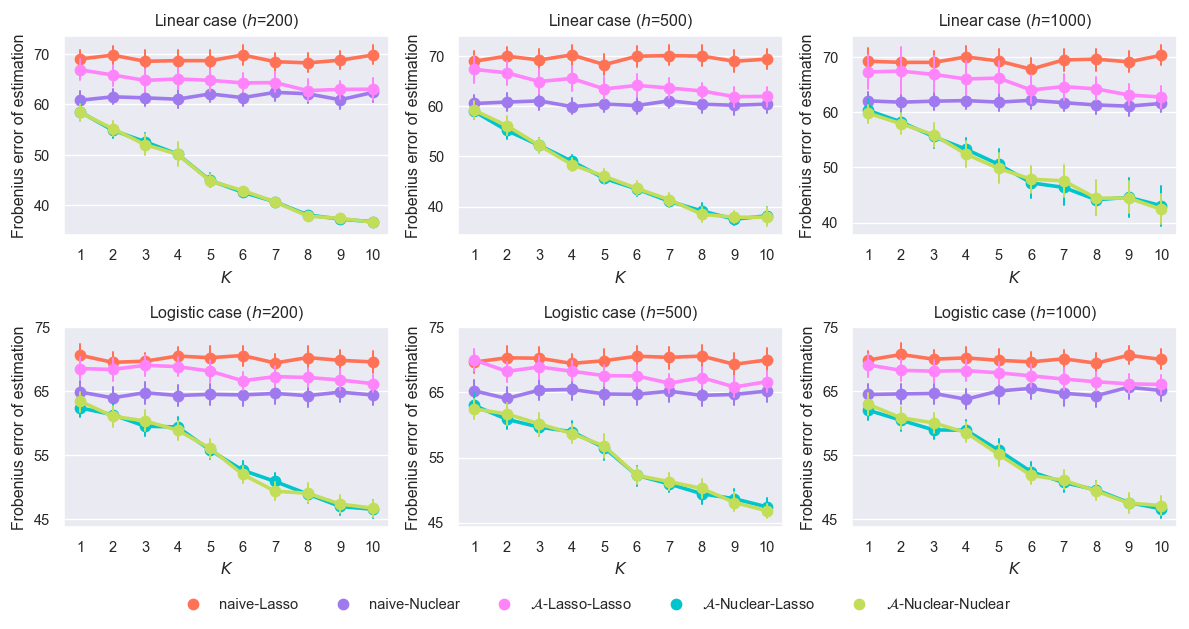

In [411]:
res_linaer = pd.read_csv("./results/simulation_sec4_knownA_sigma_linear.csv")
res_logistic = pd.read_csv("./results/simulation_sec4_knownA_sigma_logistic.csv")
plot_simulation(res_linaer,res_logistic,[200,500,1000],"K","err",10,[35,73],[43,73])

## Section4.2: Transfer learning under unknown $\mathcal{A}$

In [488]:
# plot simulation results
def plot_simulation(res_linear,res_logistic,h_list,x,y,K,ylims1=None,ylims2=None):
    fig, ax = plt.subplots(2,3,figsize=(10,5),dpi=120)
    ax = ax.flatten()
    sns.set_style("darkgrid")
    sns.set_context("paper")
    for i, h in enumerate(h_list):
        l = sns.pointplot(data=res_linear.loc[res_linear["h"]==h],
            x=x,y=y,hue="method",ax=ax[i],palette=["#FF7256","#00c5cd","#9f79ee","#ff83fa","#c2dd58"],ci=95,errwidth=1.2,scale=1)
        ax[i].set_title("Linear case ($h$=%d)"%(h))
        ax[i].get_legend().remove()
        ax[i].set_xticks(list(range(0,K+1)))
        ax[i].set_xticklabels(list(range(0,K+1)))
        ax[i].set_ylabel("Frobenius error of estimation")
        ax[i].set_xlabel("$K_{\mathcal{A}_h}$")
        ax[i].set_yticks([40,50,60,70,80,90])
        # ax[i].set_ylim([33,92])
        # ax[i].set_ylim(ylims1)
    for i, h in enumerate(h_list):
        l = sns.pointplot(data=res_logistic.loc[res_logistic["h"]==h],
            x=x,y=y,hue="method",ax=ax[i+3],palette=["#FF7256","#00c5cd","#9f79ee","#ff83fa","#c2dd58"],ci=95,errwidth=1.2,scale=1)
        ax[i+3].set_title("Logistic case ($h$=%d)"%(h))
        ax[i+3].get_legend().remove()
        ax[i+3].set_xticks(list(range(0,K+1)))
        ax[i+3].set_xticklabels(list(range(0,K+1)))
        ax[i+3].set_ylabel("Frobenius error of estimation")
        ax[i+3].set_xlabel("$K_{\mathcal{A}_h}$")
        ax[i+3].set_ylim([42,78])
        # ax[i+3].set_ylim(ylims2)
    lines=[]
    labels=["naive-Nuclear","$\mathcal{A}$-Nuclear-Nuclear","Nuclear-Nuclear","Pooled-Nuclear-Nuclear"]
    for ax in fig.axes[0:1]:
        axLine, axLabel = ax.get_legend_handles_labels()
        lines.extend(axLine)
    fig.legend(
        lines[0:5], labels[0:5],loc="lower center",
        bbox_to_anchor=(0.5, -0.05), ncol=5, 
        title=None, frameon=False,edgecolor="red")
    plt.tight_layout()

### Under Setting $\mathcal{A}_h^{vec}$

In [4]:
def Sec42_simulation(
    models : list, coef_func : Callable, data_func : Callable, task : str,
    h_list : list, Kmax : int=10, replicate : int=10, optimal_lambda : Optional[dict]=None,
    scale : str='auto', base : bool=True, n_jobs : int=16, u : float=0.1):
    def create_A_set(model, Kmax, Ka):
        if "naive" in model:
            A = None
        elif "Pooled" in model:
            A = list(range(Kmax))
        elif "A" in model:
            A = list(range(Ka)) if Ka > 0 else None
        else:
            A = list(range(Ka))
            # randomly pop
            n = np.random.binomial(Ka,u)
            while n > 0:
                A.pop()
                n -= 1
            # randomly insert
            n = np.random.binomial(Kmax-Ka,u)
            i = Ka
            while n > 0:
                A.append(i)
                n -= 1
                i += 1
        return A

    # init result
    result = pd.DataFrame(data=None,columns=["h","K","repeat","method","err","score"])
    pbar = tqdm(total=len(h_list)*(Kmax+1),ncols=120)

    for h in h_list:
        for K in range(0,Kmax+1):
            # update progress
            pbar.set_description("Fitting on h: %4d, K: %2d..."%(h,K))
            param_list = []
            for repeat in range(replicate):
                B, W = coef_func(h=h,K=Kmax,Ka=K)
                X_target, X_source, y_target, y_source = data_func(B=B,W=W,scale=scale)
                for m in models:
                    model = CreateModel(model=m,task=task)
                    A = create_A_set(model=m,Kmax=Kmax,Ka=K)
                    lambda_transfer = optimal_lambda["transfer_%s"%(m)] * np.sqrt(np.log(64*64)/(len(X_target) + 0*len(X_source[0]))) \
                        if base else optimal_lambda["transfer_%s"%(m)]
                    lambda_debias = optimal_lambda["debias_%s"%(m)] * np.sqrt(np.log(64*64)/(len(X_target) )) \
                        if base else optimal_lambda["debias_%s"%(m)]
                    param = {
                        "model": m, "task": task, "A_set": A, 
                        "lambda_transfer": lambda_transfer,
                        "lambda_debias": lambda_debias,
                        "X_target": X_target, "y_target": y_target,
                        "X_source": X_source, "y_source": y_source,
                        "B": B, "h": h, "K": K, "repeat": repeat+1
                    }
                    param_list.append(param.copy())
            # multi-process accelerated
            res = multi_task(metrics_helper,param_list,n_job=n_jobs,verbose=False)
            # save result
            for i,r in enumerate(res):
                row = len(result)
                result.loc[row,"h"] = r["h"]
                result.loc[row,"K"] = r["K"]
                result.loc[row,"repeat"] = r["repeat"]
                result.loc[row,"method"] = r["model"]
                result.loc[row,"err"] = r["metrics"][0]
                result.loc[row,"score"] = r["metrics"][1]
            pbar.update(1)
    
    pbar.clear()
    pbar.close()
    return result

### Linear Case

In [12]:
# init results
models = ["naive-Nuclear","A-Nuclear-Nuclear","Nuclear-Nuclear","Pooled-Nuclear-Nuclear"]
# models = ["A-Lasso-Lasso","A-Nuclear-Lasso","A-Nuclear-Nuclear"]
optimal_lambdas = {
    200:{
    "transfer_naive-Nuclear": 0, "debias_naive-Nuclear": 1*1e-3,
    "transfer_Pooled-Nuclear-Nuclear": 10*1e-2, "debias_Pooled-Nuclear-Nuclear": 10*1e-2,
    "transfer_Nuclear-Nuclear": 10*1e-2, "debias_Nuclear-Nuclear": 10*1e-2,
    "transfer_A-Nuclear-Nuclear": 10*1e-2, "debias_A-Nuclear-Nuclear":10*1e-2},
    500:{
    "transfer_naive-Nuclear": 0, "debias_naive-Nuclear": 5*1e-3,
    "transfer_Pooled-Nuclear-Nuclear": 25*1e-2, "debias_Pooled-Nuclear-Nuclear": 3*1e-2,
    "transfer_Nuclear-Nuclear": 25*1e-2, "debias_Nuclear-Nuclear": 3*1e-2,
    "transfer_A-Nuclear-Nuclear": 25*1e-2, "debias_A-Nuclear-Nuclear": 3*1e-2},
    1000:{
    "transfer_naive-Nuclear": 0, "debias_naive-Nuclear": 1*1e-3,
    "transfer_Pooled-Nuclear-Nuclear": 60*1e-2, "debias_Pooled-Nuclear-Nuclear": 10*1e-2,
    "transfer_Nuclear-Nuclear": 60*1e-2, "debias_Nuclear-Nuclear": 10*1e-2,
    "transfer_A-Nuclear-Nuclear": 60*1e-2, "debias_A-Nuclear-Nuclear": 10*1e-2},
}
h_list = [1000]
result = Sec42_simulation(
    models=models,task="regression",h_list=h_list,
    coef_func=GenerateCoef_sigma_unknown,data_func=regression_data,
    replicate=100,Kmax=10,scale="auto",n_jobs=16,
    optimal_lambda=optimal_lambdas[1000],base=True)
# result.to_csv("./results/simulation_sec4_knownA_vec_logistic.csv",index=False)
result.head()

Fitting on h: 1000, K: 10...: 100%|████████████████████████████████████████████████████| 11/11 [19:08<00:00, 104.44s/it]


,h,K,repeat,method,err,score
0,1000,0,1,naive-Nuclear,53.831498,0.001015
1,1000,0,1,A-Nuclear-Nuclear,55.190579,0.714294
2,1000,0,1,Nuclear-Nuclear,55.190579,0.714294
3,1000,0,1,Pooled-Nuclear-Nuclear,55.190579,0.714294
4,1000,0,2,naive-Nuclear,63.751599,0.00173


### Binary Logistic Case (Fixed)

In [5]:
# init results
models = ["naive-Nuclear","A-Nuclear-Nuclear","Nuclear-Nuclear","Pooled-Nuclear-Nuclear"]
optimal_lambdas = {
    "transfer_naive-Nuclear": 0, "debias_naive-Nuclear": 3e-2,
    "transfer_Pooled-Nuclear-Nuclear": 3e-2, "debias_Pooled-Nuclear-Nuclear": 4e-2,
    "transfer_Nuclear-Nuclear": 3e-2, "debias_Nuclear-Nuclear": 4e-2,
    "transfer_A-Nuclear-Nuclear": 3e-2, "debias_A-Nuclear-Nuclear": 4e-2}
h_list = [200,500,1000]
result = Sec42_simulation(
    models=models,task="classification",h_list=h_list,
    coef_func=GenerateCoef_sigma_unknown,data_func=binary_logistic_data,
    replicate=100,Kmax=10,scale="auto",n_jobs=12,
    optimal_lambda=optimal_lambdas,base=True)
# result.to_csv("./results/simulation_sec4_knownA_vec_logistic.csv",index=False)
result.head()

Fitting on h: 1000, K: 10...: 100%|████████████████████████████████████████████████████| 33/33 [56:19<00:00, 102.42s/it]


,h,K,repeat,method,err,score
0,200,0,1,naive-Nuclear,65.127024,1.0
1,200,0,1,A-Nuclear-Nuclear,64.516633,0.92
2,200,0,1,Nuclear-Nuclear,64.504283,0.935
3,200,0,1,Pooled-Nuclear-Nuclear,64.516633,0.92
4,200,0,2,naive-Nuclear,69.553526,1.0


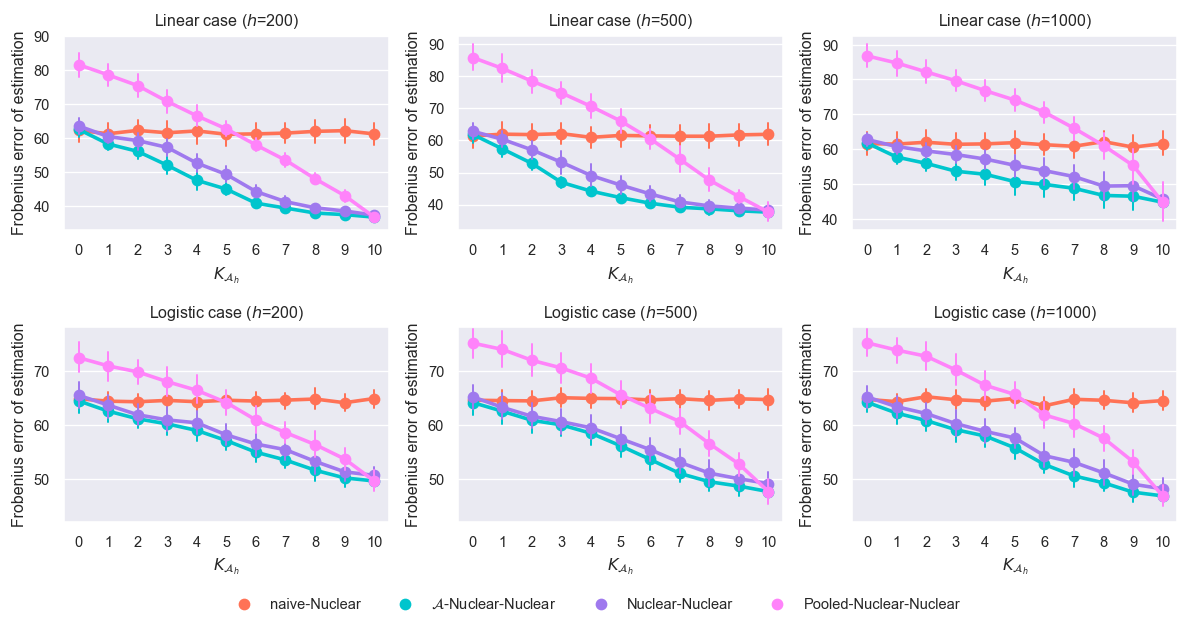

In [489]:
res_linaer = pd.read_csv("./results/simulation_sec4_unknownA_sigma_linear.csv")
res_logistic = pd.read_csv("./results/simulation_sec4_unknownA_sigma_logistic.csv")
plot_simulation(res_linaer,res_logistic,[200,500,1000],"K","err",10,[35,73],[60,66])